In [ ]:
## https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [3]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier ## GBM algorithm
from sklearn import cross_validation,metrics 
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol ='ID'

train['Disbursed'] = train.Disbursed.astype(int)

In [4]:
### Before proceeding further, lets define a function which will help us create GBM models and perform cross-validation.

def modelfit(alg, dtrain,dtest, predictors, performCV = True, printFeatureImportance=True, cv_folds= 5):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain['Disbursed'])
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    ## Perform cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors],dtrain['Disbursed'],
                                                    cv = cv_folds,scoring='roc_auc')
    #Print model report:
    print("\nModel Report")
    print("Accuracy : {:.4g}".format(metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)))
    print("AUC Score (Train): {:.4f}".format( metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)))
    
    if performCV:
        #print( "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g",
        #      (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print( "CV Score : Mean - {:.7g} | Std - {:.7g} | Min - {:.7g} | Max - {:.7g}".format(
              np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    

<h1>Baseline Model<h1>
Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.8623
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


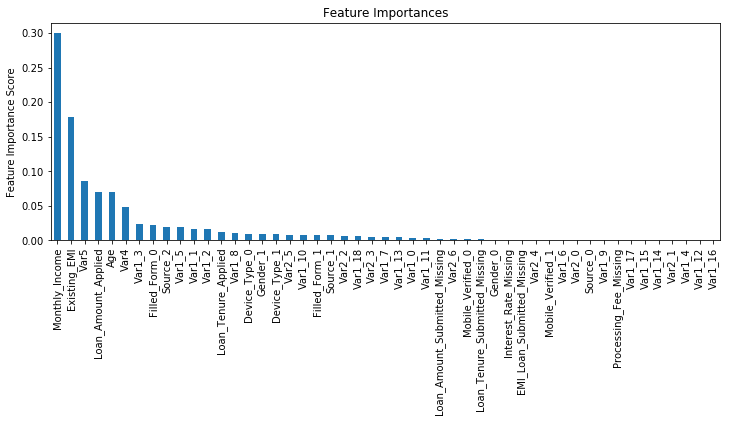

In [9]:
## def modelfit(alg, dtrain, predictors, performCV = True, printFeatureImportance=True, cv_folds= 5):
test = pd.read_csv('test_modified.csv')
##Choose all predictors except target & IDcols

predictors = [ x for x in train.columns if x not in [target,IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, test, predictors) #,printOOB=False)

In [ ]:
#train['Disbursed'].value_counts()

GBM Models:

There 2 types of parameters here:

Tree-specific parameters

min_samples_split

min_samples_leaf
max_depth
min_leaf_nodes
max_features
loss function
Boosting specific paramters
n_estimators
learning_rate
subsample
Approach for tackling the problem
Decide a relatively higher value for learning rate and tune the number of estimators requried for that.
Tune the tree specific parameters for that learning rate
Tune subsample
Lower learning rate as much as possible computationally and increase the number of estimators accordingly.
Step 1- Find the number of estimators for a high learning rate
We will use the following benchmarks for parameters:
min_samples_split = 500 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.
max_depth = 8 : since high number of observations and predictors, choose relatively high value
max_features = 'sqrt' : general thumbrule to start with
subsample = 0.8 : typically used value (will be tuned later)
0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

In [10]:
#Choose all predictors except target & IDcols
predictors = [ x for x in train.columns if x not in [ target, IDcol]]
param_test1 = { 'n_estimators': range(20,81,10)}

estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10)
gsearch1 = GridSearchCV(estimator, param_grid = param_test1, scoring='roc_auc', iid = False, cv =5 )
gsearch1.fit(train[predictors], train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [11]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\prassha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83337, std: 0.00991, params: {'n_estimators': 20},
  mean: 0.83697, std: 0.00994, params: {'n_estimators': 30},
  mean: 0.83832, std: 0.01050, params: {'n_estimators': 40},
  mean: 0.83867, std: 0.01081, params: {'n_estimators': 50},
  mean: 0.83939, std: 0.01077, params: {'n_estimators': 60},
  mean: 0.83891, std: 0.01044, params: {'n_estimators': 70},
  mean: 0.83807, std: 0.01093, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.83938802668613077)

In [12]:
##Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators =60, max_features='sqrt',
                                                              subsample =0.8, random_state=10),
                       param_grid = param_test2,scoring = 'roc_auc',iid = False, cv =5 )
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=60, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [13]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\prassha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83297, std: 0.01226, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.83251, std: 0.01054, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.83386, std: 0.01415, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.83379, std: 0.01169, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.83339, std: 0.01266, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83365, std: 0.00787, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.83663, std: 0.00991, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83480, std: 0.00828, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.83786, std: 0.01067, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.83769, std: 0.01060, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83581, std: 0.01003, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83729, std: 0.00959, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [15]:
param_test3 = {'min_samples_split': range(800,2100,200),'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators =60, 
                                                              max_depth=9,max_features='sqrt', subsample = 0.8,
                                                              random_state=10),
                       param_grid= param_test3,scoring= 'roc_auc',iid=False,cv=5)
gsearch3.fit(train[predictors], train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=60, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_split': range(800, 2100, 200), 'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [17]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\prassha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83821, std: 0.01128, params: {'min_samples_leaf': 30, 'min_samples_split': 800},
  mean: 0.83821, std: 0.01092, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.83876, std: 0.01262, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.83552, std: 0.01024, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.83683, std: 0.01429, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.83958, std: 0.01233, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.83852, std: 0.01097, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.83701, std: 0.01214, params: {'min_samples_leaf': 40, 'min_samples_split': 800},
  mean: 0.83839, std: 0.00896, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.83757, std: 0.01274, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.83757, std: 0.01074, params: {'min_samples_leaf': 40, 'min_samples_split

In [19]:
gsearch3.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=60,
              min_samples_split=1200, min_weight_fraction_leaf=0.0,
              n_estimators=60, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.8965
CV Score : Mean - 0.8397598 | Std - 0.009936017 | Min - 0.8255474 | Max - 0.8527672


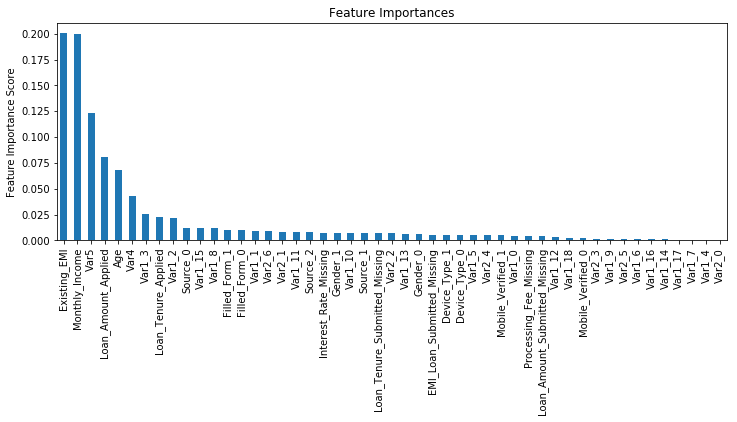

In [20]:
modelfit(gsearch3.best_estimator_, train,test,predictors)

In [22]:
## Tune max_features:
param_test4 = {'max_features': range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 60, max_depth=9,
                                                              min_samples_split=1200,min_samples_leaf=60,
                                                              subsample=0.8,random_state=10),
                       param_grid =param_test4,scoring='roc_auc',iid=False,cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=60,
              min_samples_split=1200, min_weight_fraction_leaf=0.0,
              n_estimators=60, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_features': range(7, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [23]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\prassha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83976, std: 0.00994, params: {'max_features': 7},
  mean: 0.83648, std: 0.00988, params: {'max_features': 9},
  mean: 0.83919, std: 0.01042, params: {'max_features': 11},
  mean: 0.83738, std: 0.01017, params: {'max_features': 13},
  mean: 0.83898, std: 0.01101, params: {'max_features': 15},
  mean: 0.83437, std: 0.00965, params: {'max_features': 17},
  mean: 0.83524, std: 0.01018, params: {'max_features': 19}],
 {'max_features': 7},
 0.83975976288429499)

In [24]:
## Step3- Tune Subsample and Lower Learning Rate
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10, max_features=7),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=60,
              min_samples_split=1200, min_weight_fraction_leaf=0.0,
              n_estimators=60, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\prassha\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83645, std: 0.00942, params: {'subsample': 0.6},
  mean: 0.83685, std: 0.01242, params: {'subsample': 0.7},
  mean: 0.83601, std: 0.01074, params: {'subsample': 0.75},
  mean: 0.83976, std: 0.00994, params: {'subsample': 0.8},
  mean: 0.84086, std: 0.00997, params: {'subsample': 0.85},
  mean: 0.83828, std: 0.00984, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.84085800832187396)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.8976
CV Score : Mean - 0.8391332 | Std - 0.009437997 | Min - 0.8271238 | Max - 0.8511221


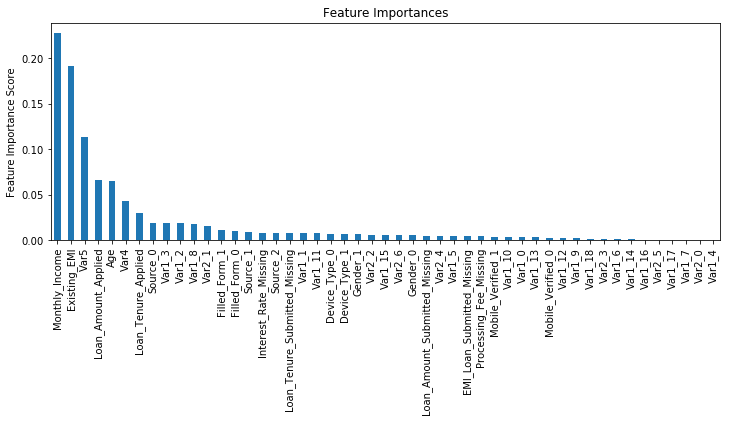

In [30]:
####  With all tuned lets try reducing the learning rate and proportionally 
#### increasing the number of estimators to get more robust results:
#Choose all predictors except target & IDcols
predictors = [ x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate= 0.05, n_estimators = 120, max_depth=9, min_samples_split=1200,
                                       min_samples_leaf=60,subsample=0.85,random_state=10,max_features=7)
modelfit(gbm_tuned_1, train,test,predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.9000
CV Score : Mean - 0.8408728 | Std - 0.01020728 | Min - 0.8255379 | Max - 0.8526328


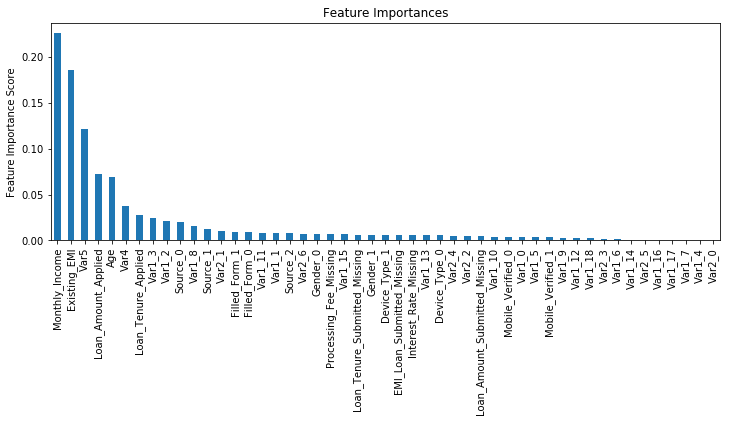

In [33]:
## 1/10th learning rate
predictors = [x for x in train.columns if x not in [target,IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate = .01, n_estimators = 600, max_depth=9, min_samples_split=1200,
                                        min_samples_leaf=60, subsample=0.85,random_state=10,max_features=7)
modelfit(gbm_tuned_2,train,test,predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.9007


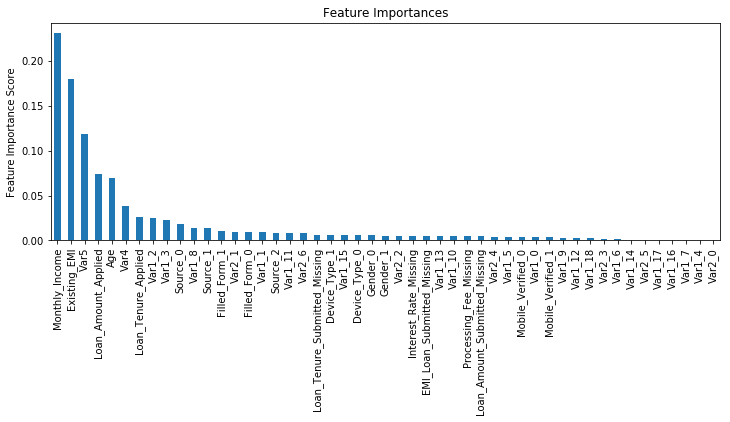

In [34]:
### 1/50th learning rate
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
                                         warm_start=True)
modelfit(gbm_tuned_3, train, test, predictors, performCV=False)